# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import json
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [5]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [16]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext, HiveContext
from pyspark.sql.functions import col, array_contains, explode, split, length
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import sum as summation

conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc) #HiveContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [3]:
!hdfs dfs -copyFromLocal data .

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-16 09:22 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-16 09:23 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-16 09:23 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-16 09:23 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-16 09:23 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-16 09:23 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-16 09:23 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-16 09:23 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-16 09:24 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [6]:
ratings = sc.textFile(RATINGS_PATH)

In [7]:
%%time
ratings.take(5)

CPU times: user 20.8 ms, sys: 3.4 ms, total: 24.2 ms
Wall time: 3.26 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions()

5

In [7]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
ratings.count()

25000095

Количество пользователей

In [11]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 60.6 ms, sys: 17 ms, total: 77.5 ms
Wall time: 52.8 s


162541

Сохраним датасет в память

In [9]:
ratings = ratings.persist()

In [8]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 20 ms, sys: 50 ms, total: 70 ms
Wall time: 1min 28s


162541

Количество фильмов

In [12]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 31.8 ms, sys: 14.7 ms, total: 46.4 ms
Wall time: 55.6 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [8]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [160]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [24]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [25]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-02 17:18 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58976 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112528 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131435 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114337 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133615 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117755 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     142933 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132298 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167627 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [13]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [27]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [28]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

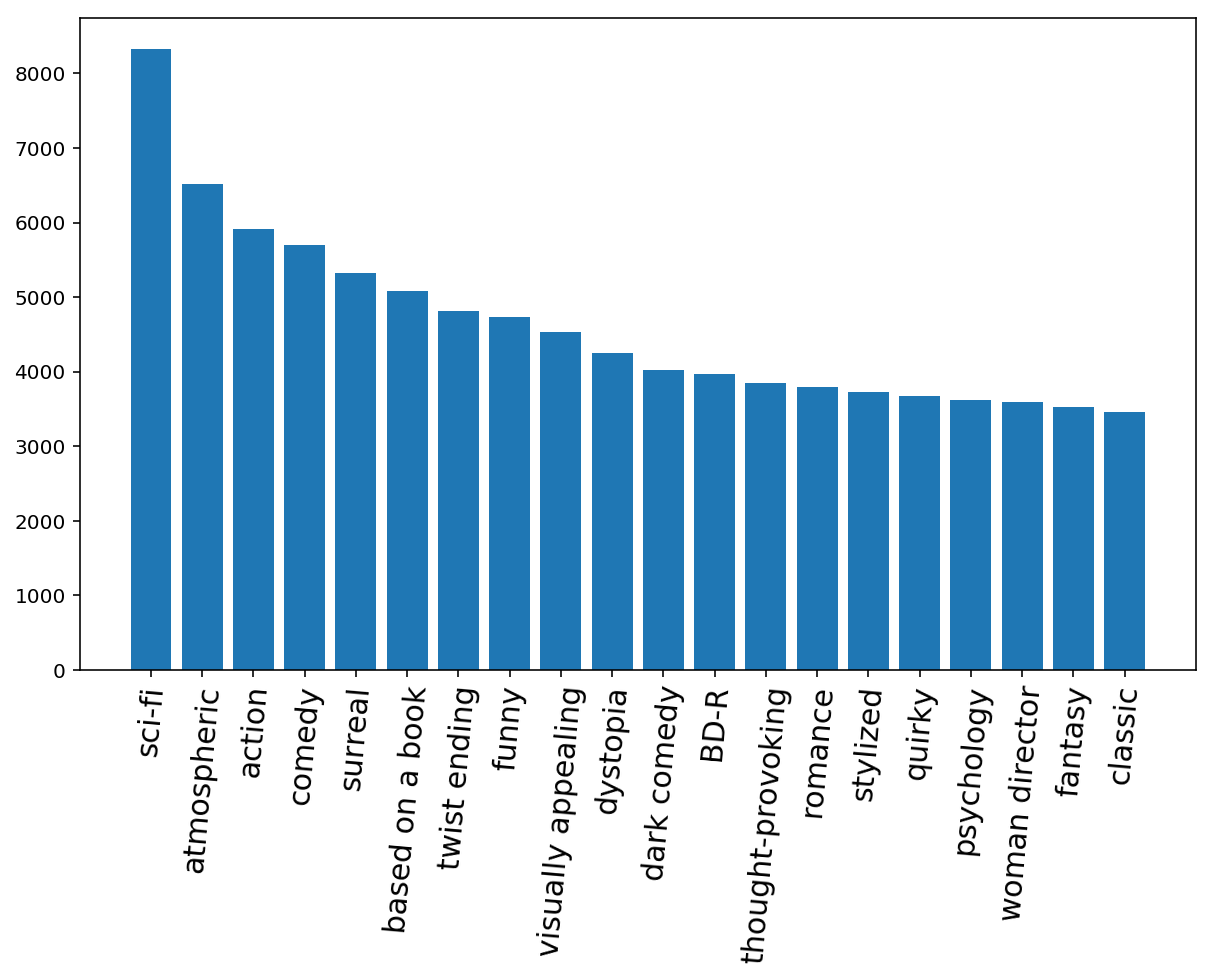

In [29]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [44]:
movie_max_num_rating = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) 

movie_max_num_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)

[(356, (81491, ['356', 'Forrest Gump (1994)'])),
 (318, (81482, ['318', '"Shawshank Redemption'])),
 (296, (79672, ['296', 'Pulp Fiction (1994)'])),
 (593, (74127, ['593', '"Silence of the Lambs'])),
 (2571, (72674, ['2571', '"Matrix'])),
 (260, (68717, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (480, (64144, ['480', 'Jurassic Park (1993)'])),
 (527, (60411, ['527', "Schindler's List (1993)"])),
 (110, (59184, ['110', 'Braveheart (1995)'])),
 (2959, (58773, ['2959', 'Fight Club (1999)']))]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [87]:
movie_max_num_5 = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .filter(lambda x: x[1][0] == 5) \
    .map(lambda x: (x[0], x[1][1])) \
    .reduceByKey(lambda a, b: a + b)

movie_max_num_5 \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1], ascending=False) \
    .take(10)

[(318, (39553, ['318', '"Shawshank Redemption'])),
 (296, (32169, ['296', 'Pulp Fiction (1994)'])),
 (356, (25918, ['356', 'Forrest Gump (1994)'])),
 (260, (25804, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (2571, (25482, ['2571', '"Matrix'])),
 (527, (24853, ['527', "Schindler's List (1993)"])),
 (593, (24801, ['593', '"Silence of the Lambs'])),
 (858, (24418, ['858', '"Godfather'])),
 (50, (21585, ['50', '"Usual Suspects'])),
 (2959, (21486, ['2959', 'Fight Club (1999)']))]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [98]:
movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: round(ratings[0] / ratings[1], 1)) \
    .map(lambda x: (x[1], 1))

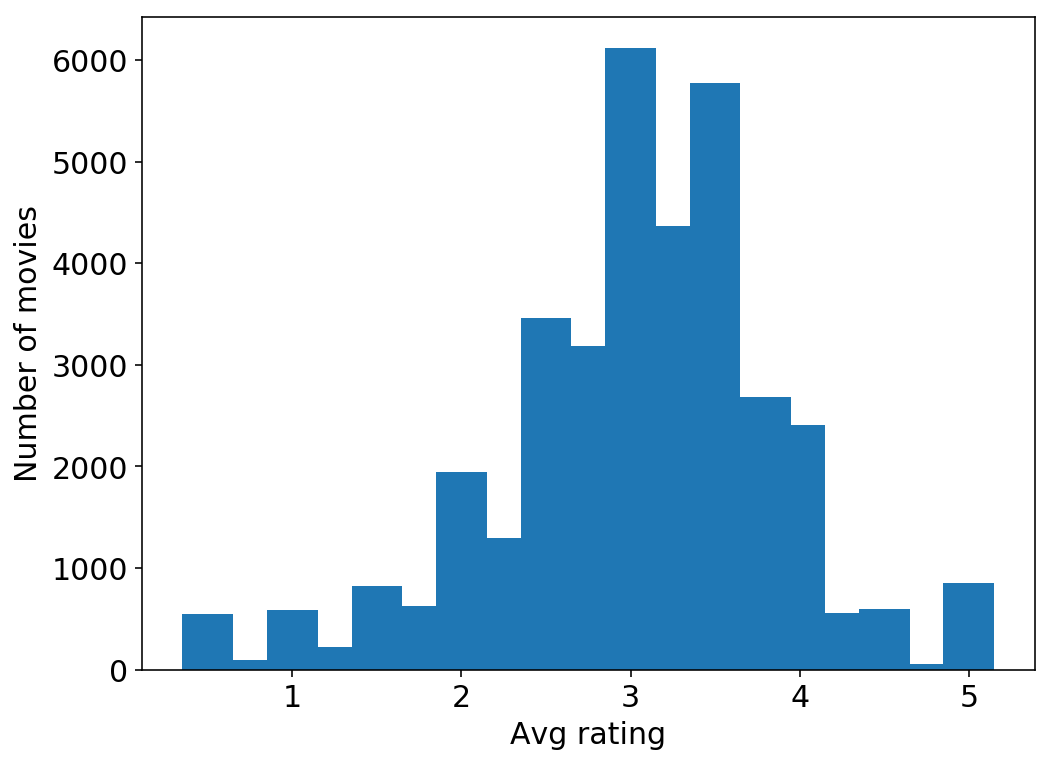

In [124]:
avg_count = movie_avg_rating \
    .reduceByKey(lambda a, b: a + b)\
    .collect()

avg_count = sorted(avg_count, key=lambda avg_count: avg_count[0])
keys, values = zip(*avg_count)

f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Avg rating', fontsize=15)
plt.ylabel('Number of movies', fontsize=15)
plt.bar(keys, values, width=0.3)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [9]:
movie_num_rating = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()
#     .map(lambda x: (x[1], 1)) \
#     .reduceByKey(lambda a, b: a + b) \
#     .collect()

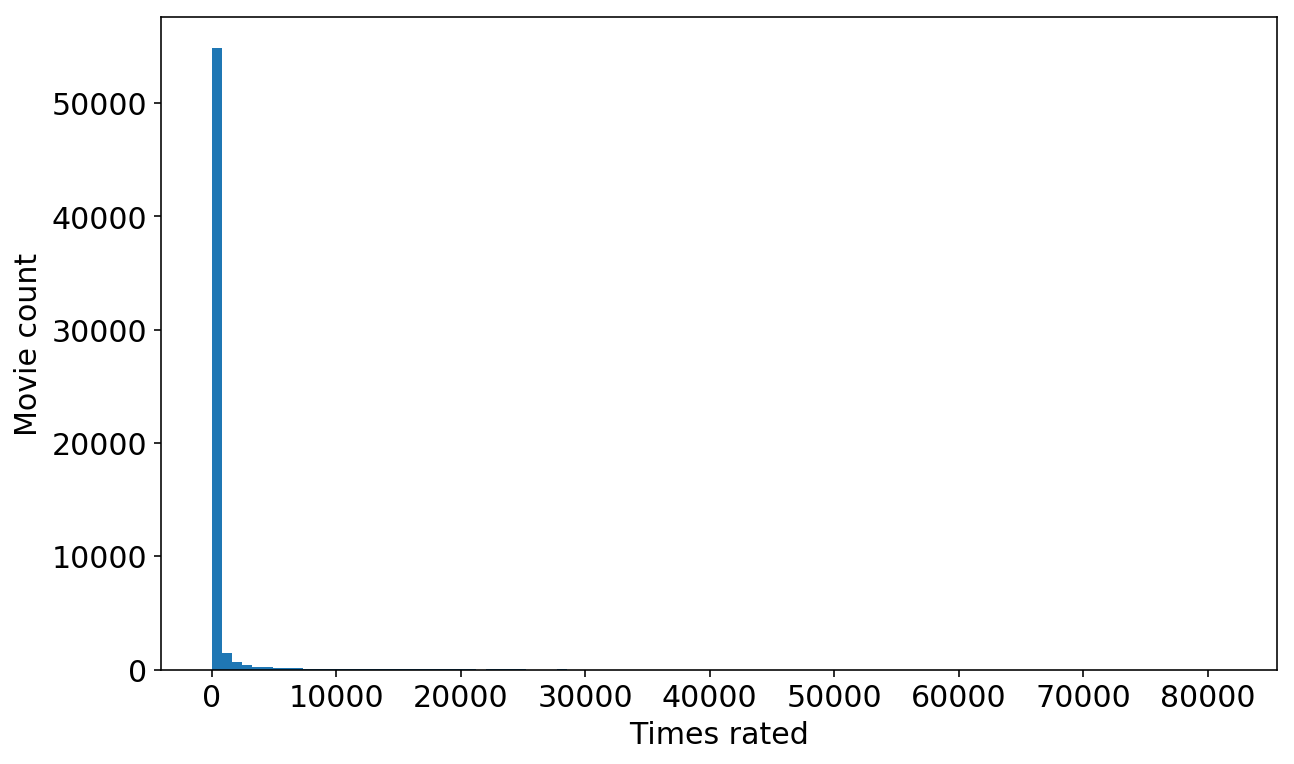

In [11]:
rating_count = sorted(movie_num_rating, key=lambda x: x[0])
keys, values = zip(*rating_count)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Times rated', fontsize=15)
plt.ylabel('Movie count', fontsize=15)
plt.hist(values, bins=100)
# plt.bar(keys, values)  # nothing shows
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [373]:
movies = sc.textFile(MOVIES_PATH)

movies = movies \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_genres = movies \
    .map(lambda x: (x[0], x[1][-1].split('|'))) \
    .flatMapValues(lambda x: (*x, 1)) \
    .filter(lambda x: isinstance(x[1], str)) \
    .map(lambda x: (x[1], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

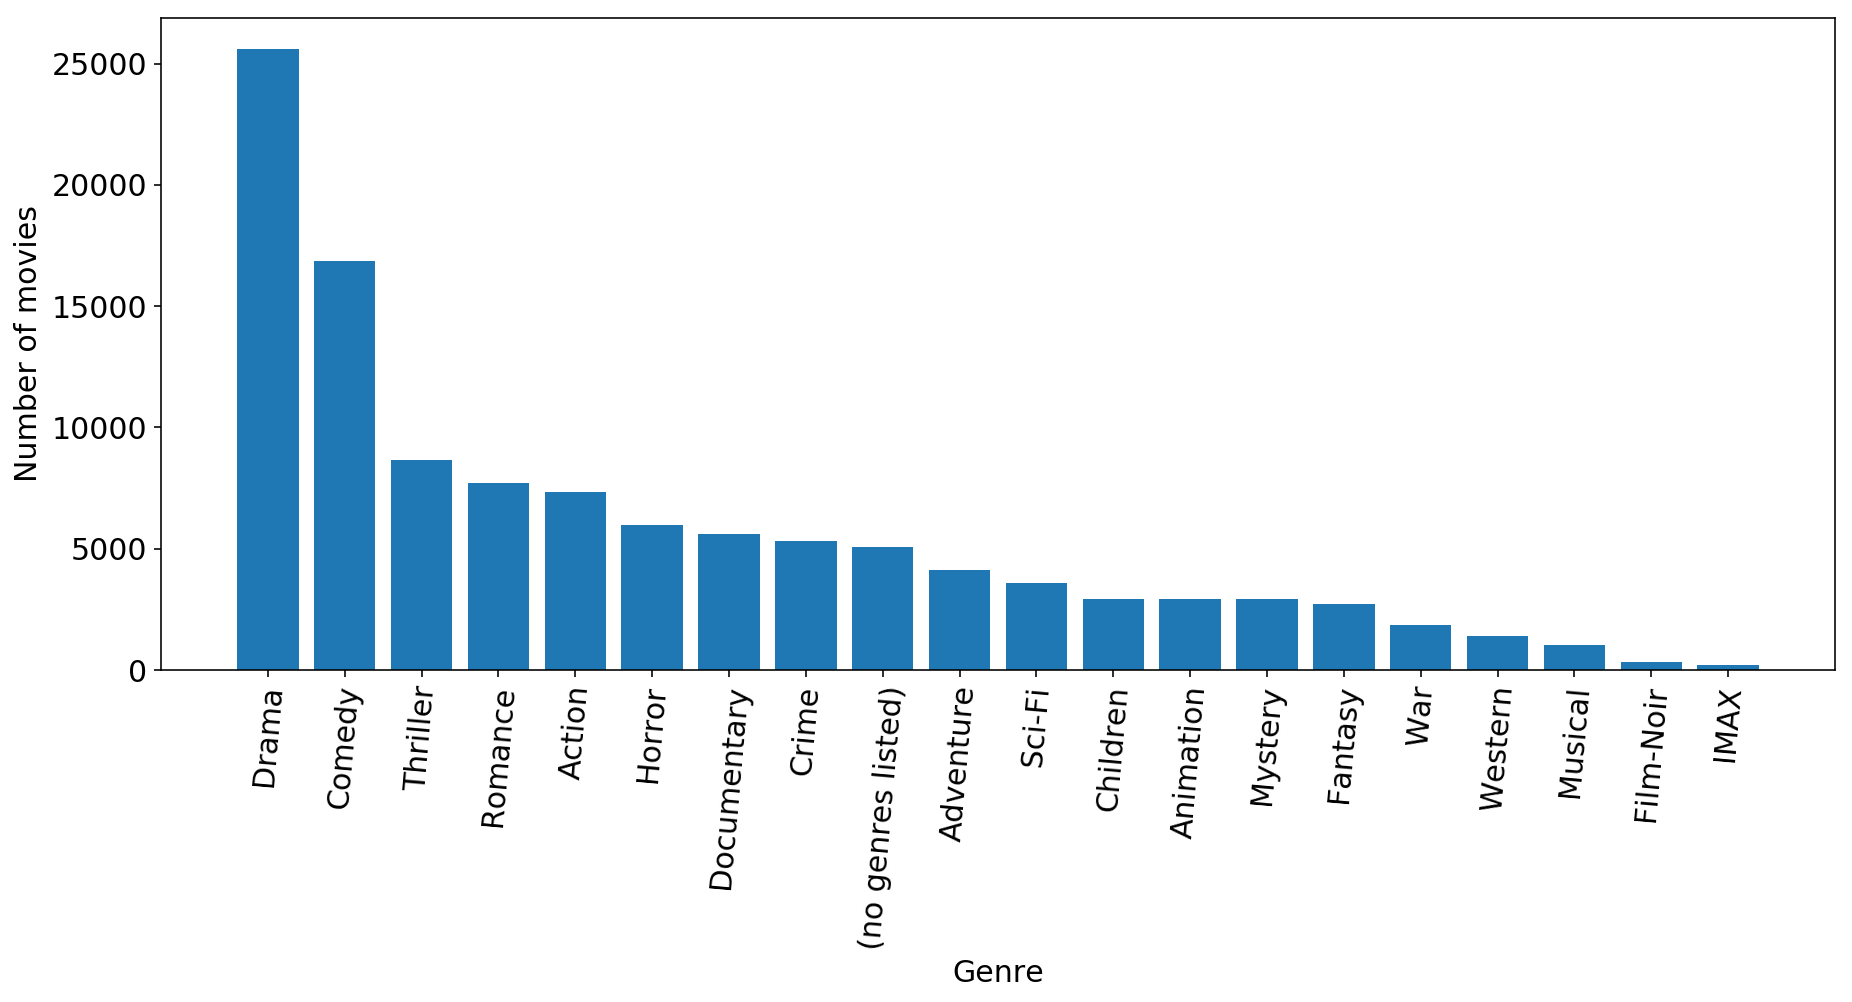

In [374]:
genres_count = sorted(movie_genres, key=lambda count: count[1], reverse=True)
keys, values = zip(*genres_count)

f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Number of movies', fontsize=15)
plt.bar(keys, values,)
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [14]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
links_pd = pd.read_csv(LINKS_PATH)   
links = sqlContext.createDataFrame(links_pd)
links = links.withColumn('tmdbId', links['tmdbId'].cast(IntegerType()))

TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')
tmdb = sqlContext.read.json(TMDB_PATH) 
tmdb.registerTempTable('tmdb')

### 1

In [161]:
movie_actor = tmdb.select(col('id').alias('movie_id'), \
    col('casts.cast.id').alias('actors_id'))

movie_actor = movie_actor.where(array_contains(movie_actor.actors_id, '31'))

tmdbId_to_movieId = links.join(movie_actor, links.tmdbId == movie_actor.movie_id)
movie_id = tmdbId_to_movieId.select('movieId')
movie_id_list = movie_id.rdd.flatMap(lambda x: x).collect()

movies_31 = movies \
    .filter(lambda x: x[0] in movie_id_list) 

In [163]:
movies_31.collect()

[(1, ['1', 'Toy Story (1995)']),
 (150, ['150', 'Apollo 13 (1995)']),
 (356, ['356', 'Forrest Gump (1994)']),
 (508, ['508', 'Philadelphia (1993)']),
 (539, ['539', 'Sleepless in Seattle (1993)']),
 (581, ['581', '"Celluloid Closet']),
 (1042, ['1042', 'That Thing You Do! (1996)']),
 (2028, ['2028', 'Saving Private Ryan (1998)']),
 (2072, ['2072', '"\'burbs']),
 (2100, ['2100', 'Splash (1984)']),
 (2375, ['2375', '"Money Pit']),
 (2418, ['2418', 'Nothing in Common (1986)']),
 (2424, ['2424', "You've Got Mail (1998)"]),
 (2797, ['2797', 'Big (1988)']),
 (2930, ['2930', 'Return with Honor (1998)']),
 (3114, ['3114', 'Toy Story 2 (1999)']),
 (3130, ['3130', 'Bonfire of the Vanities (1990)']),
 (3147, ['3147', '"Green Mile']),
 (3255, ['3255', '"League of Their Own']),
 (3385, ['3385', 'Volunteers (1985)']),
 (3525, ['3525', 'Bachelor Party (1984)']),
 (4012, ['4012', 'Punchline (1988)']),
 (4022, ['4022', 'Cast Away (2000)']),
 (4677, ['4677', 'Turner & Hooch (1989)']),
 (5183, ['5183', "

### 2

In [192]:
movie_actor = tmdb.select(explode(col('casts.cast.name')))
actor_count = movie_actor.groupBy('col').count()
actor_count.sort('count', ascending=False).take(10)

[Row(col='Bess Flowers', count=380),
 Row(col='Frank Welker', count=184),
 Row(col='Christopher Lee', count=175),
 Row(col='Clarence Nash', count=158),
 Row(col='Irving Bacon', count=152),
 Row(col='John Carradine', count=146),
 Row(col='John Wayne', count=142),
 Row(col='Mel Blanc', count=140),
 Row(col='Samuel L. Jackson', count=134),
 Row(col='Eric Roberts', count=133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [17]:
genre_year = tmdb.select(col('release_date').alias('year'), \
    explode(col('genres.name')).alias('genre'))
genre_year = genre_year.where(length(col('year')) > 0)
genre_year = genre_year.withColumn('year', split(genre_year['year'], '-').getItem(0))
genre_year_count = genre_year.groupBy('year', 'genre').count().sort('year')  

windowval = (Window.partitionBy('genre').orderBy('year'))
genre_year_cumsum = genre_year_count.withColumn('cum_count', summation('count').over(windowval))

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [371]:
genre_money = tmdb.select(explode(col('genres.name')).alias('genre'), \
    col('budget'), 
    col('revenue'))
genre_money = genre_money.groupBy('genre').mean()                         
genre_money = genre_money.withColumn('ROI', col('avg(budget)') / col('avg(revenue)'))
genre_money = genre_money.sort('ROI', ascending=False)

genre_rows = genre_money.select(col('genre')).collect()
genre = [row.genre for row in genre_rows]
roi_rows = genre_money.select(col('ROI')).collect()
roi = [row.ROI for row in roi_rows]

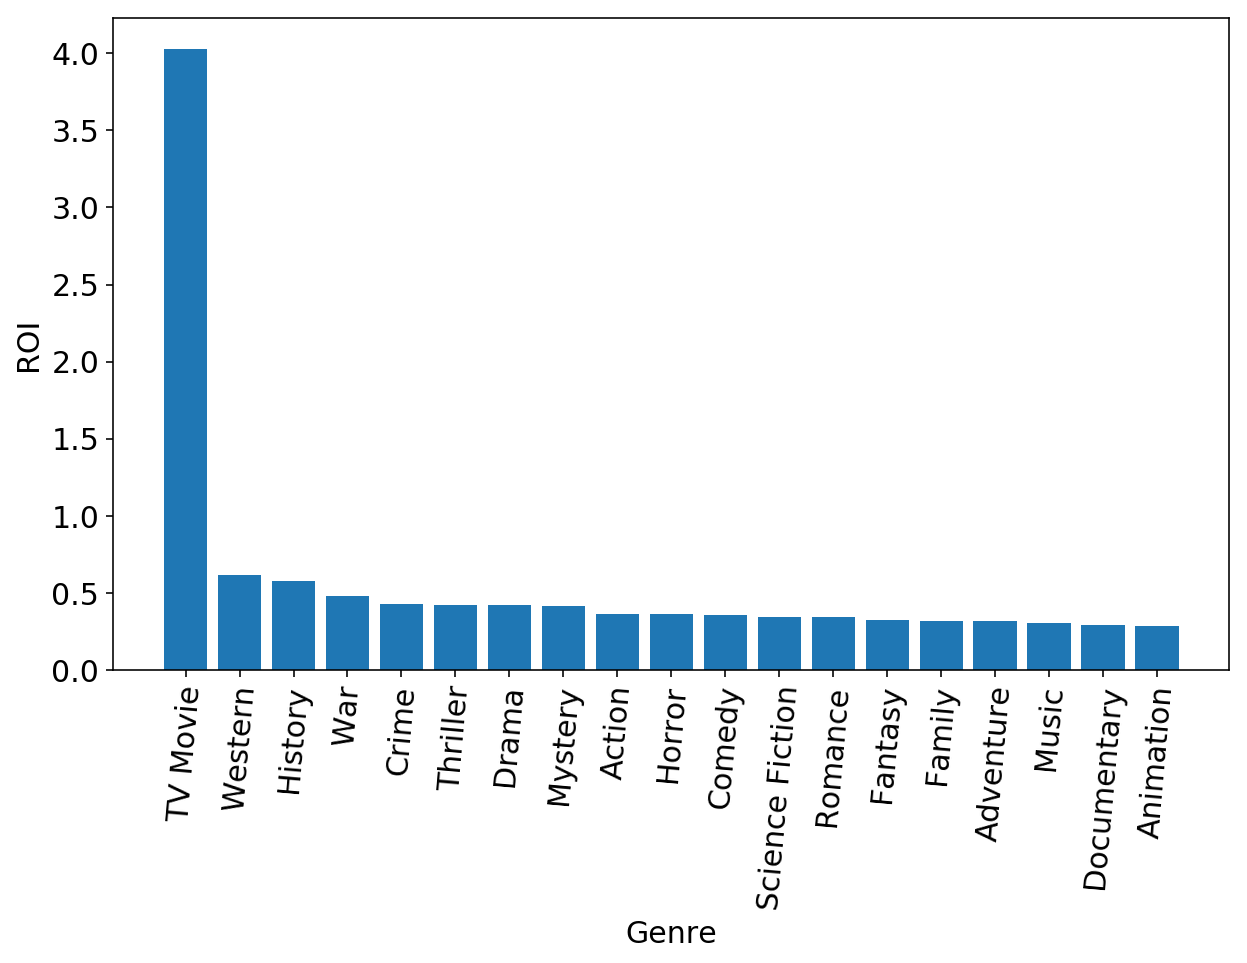

In [372]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Genre', fontsize=15)
plt.ylabel('ROI', fontsize=15)
plt.bar(genre, roi)
plt.show()